Setup and Global Helpers

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Helper to load images or create a synthetic one if the file is missing
def load_assign_image(path, gray=False):
    if os.path.exists(path):
        img = cv2.imread(path)
        if gray: return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Create a synthetic image with shapes for testing
        img = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.rectangle(img, (50, 50), (250, 250), (200, 200, 200), -1)
        cv2.circle(img, (150, 150), 60, (100, 100, 100), -1)
        if gray: return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

Question 1 (Intensity Transformations)

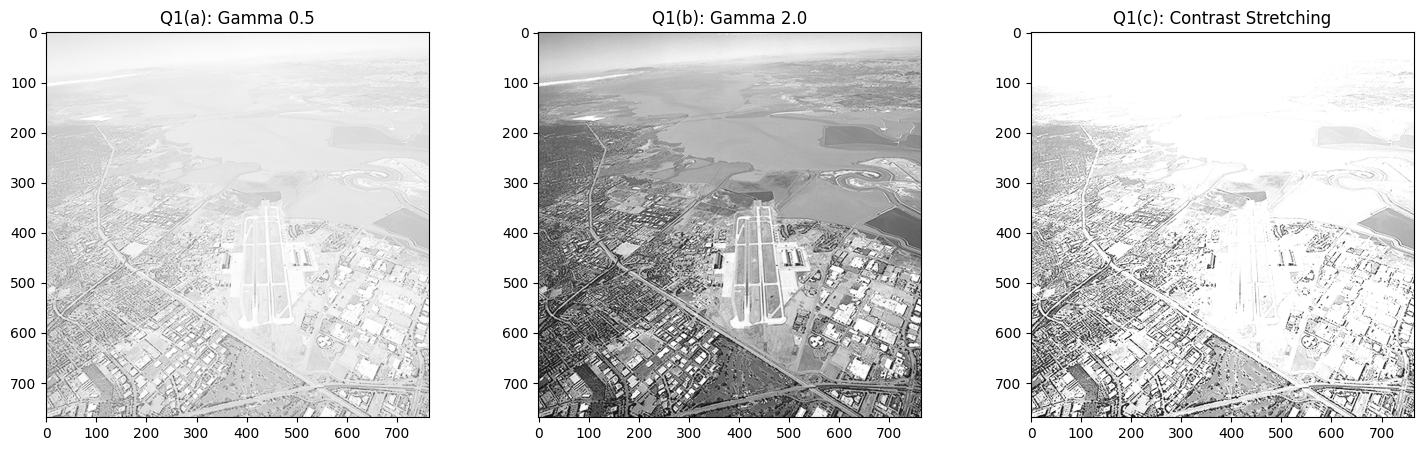

In [2]:
img = load_assign_image('Sources/runway.png', gray=True)
r = img.astype(float) / 255.0

# (a) Gamma 0.5, (b) Gamma 2.0
s05 = np.power(r, 0.5)
s20 = np.power(r, 2.0)

# (c) Contrast Stretching
r1, r2 = 0.2, 0.8
s_stretch = np.where(r < r1, 0, np.where(r > r2, 1, (r - r1) / (r2 - r1)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(s05, cmap='gray'); axes[0].set_title('Q1(a): Gamma 0.5')
axes[1].imshow(s20, cmap='gray'); axes[1].set_title('Q1(b): Gamma 2.0')
axes[2].imshow(s_stretch, cmap='gray'); axes[2].set_title('Q1(c): Contrast Stretching')
plt.show()

Question 2 (Lab Color Space Gamma)

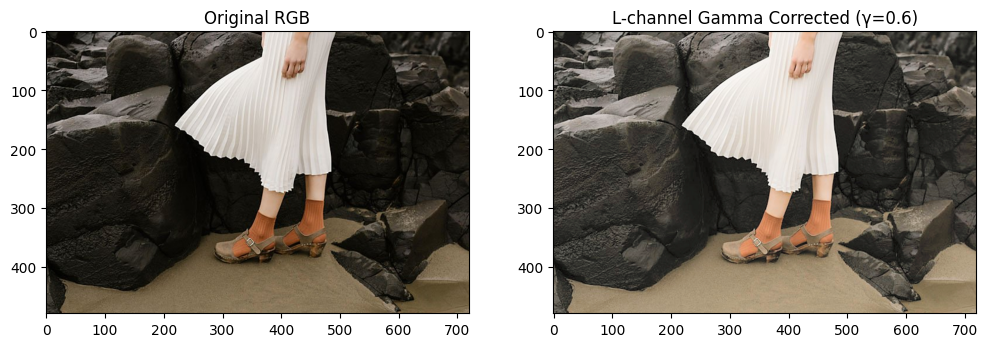

In [3]:
img_rgb = load_assign_image('Sources/highlights_and_shadows.jpg')
# Convert to LAB using OpenCV (Manual conversion is in your lab_gamma_and_hist_eq.py)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(img_lab)

# Apply Gamma to L channel (Normalized to 0-1)
gamma = 0.6
l_norm = l.astype(float) / 255.0
l_corr = np.power(l_norm, gamma)
l_final = (l_corr * 255).astype(np.uint8)

# Merge back and show
img_corr_lab = cv2.merge([l_final, a, b])
img_corr_rgb = cv2.cvtColor(img_corr_lab, cv2.COLOR_LAB2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb); axes[0].set_title('Original RGB')
axes[1].imshow(img_corr_rgb); axes[1].set_title(f'L-channel Gamma Corrected (γ={gamma})')
plt.show()

Question 3 (Manual Histogram Equalization)

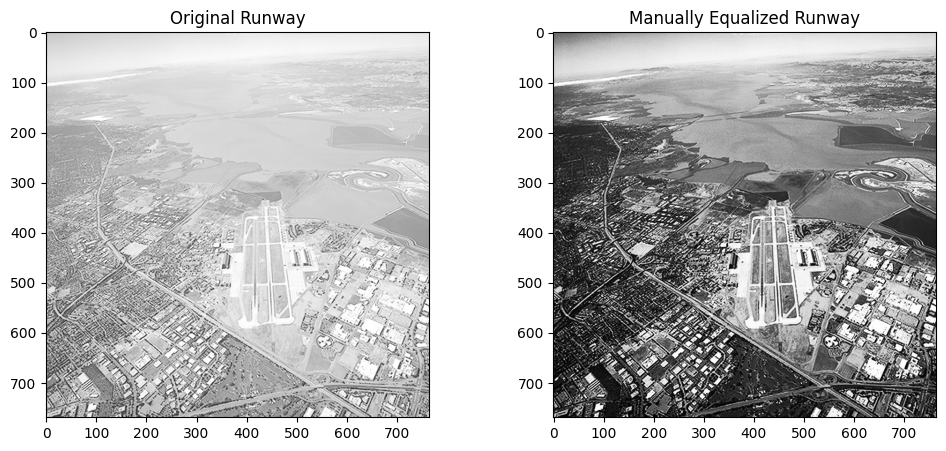

In [4]:
img_gray = load_assign_image('Sources/runway.png', gray=True)

# Manual Histogram Equalization logic
hist, _ = np.histogram(img_gray.flatten(), 256, [0, 256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf_final = np.ma.filled(cdf_m, 0).astype(np.uint8)
img_eq = cdf_final[img_gray]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(img_gray, cmap='gray'); plt.title('Original Runway')
plt.subplot(1, 2, 2); plt.imshow(img_eq, cmap='gray'); plt.title('Manually Equalized Runway')
plt.show()

Question 4 (Otsu Threshold & Masked Equalization)

Otsu Threshold Value: 101.0


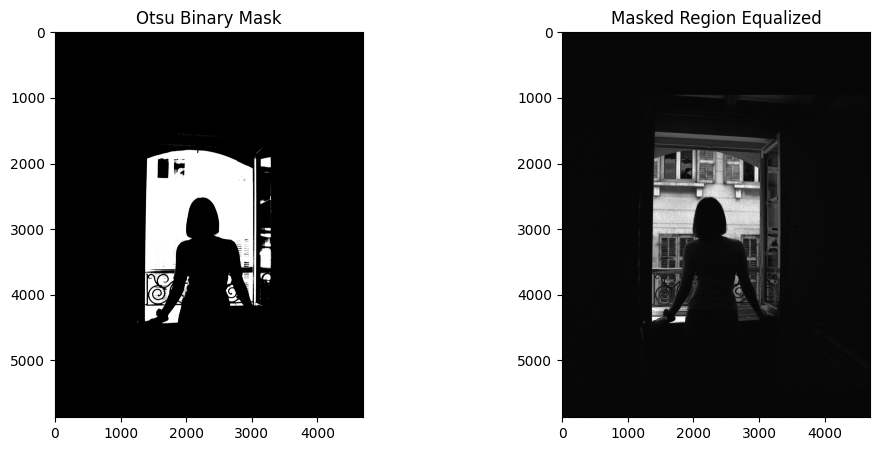

In [5]:
img_q4 = load_assign_image('Sources/looking_out.jpg', gray=True)

# (a) Otsu Thresholding
val, mask = cv2.threshold(img_q4, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu Threshold Value: {val}")

# (b) Equalize only the foreground (where mask is white)
res = img_q4.copy()
m_pixels = img_q4[mask == 255]
h_m, _ = np.histogram(m_pixels, 256, [0, 256])
c_m = h_m.cumsum()
c_norm = ((c_m - c_m.min()) * 255 / (m_pixels.size - c_m.min())).astype(np.uint8)
res[mask == 255] = c_norm[img_q4[mask == 255]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(mask, cmap='gray'); plt.title("Otsu Binary Mask")
plt.subplot(1, 2, 2); plt.imshow(res, cmap='gray'); plt.title("Masked Region Equalized")
plt.show()

Question 5 (Gaussian Filtering)

5x5 Normalized Gaussian Kernel:
 [[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]


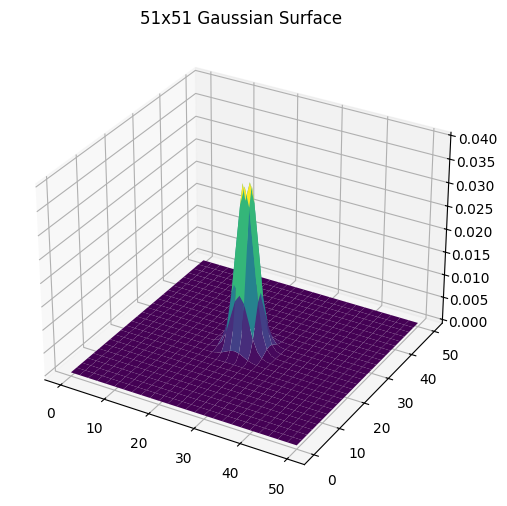

In [6]:
def g_kernel(size, sigma):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# (a) 5x5 Kernel
k5 = g_kernel(5, 2)
print("5x5 Normalized Gaussian Kernel:\n", k5)

# (b) 51x51 Visualization
k51 = g_kernel(51, 2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax.plot_surface(X, Y, k51, cmap='viridis'); ax.set_title("51x51 Gaussian Surface")
plt.show()

Question 6 (Derivative of Gaussian)

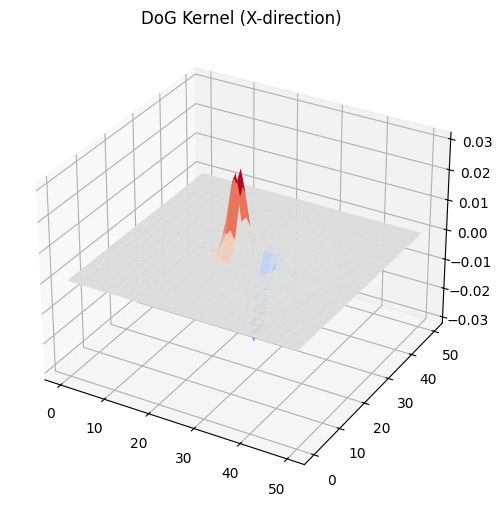

In [7]:
def dog_kernel(size, sigma, dir='x'):
    c = size // 2
    y, x = np.ogrid[-c:c+1, -c:c+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    k = -(x/sigma**2)*g if dir=='x' else -(y/sigma**2)*g
    return k / np.sum(np.abs(k))

# 3D Visualization of x-derivative
k_dog = dog_kernel(51, 2, 'x')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax.plot_surface(X, Y, k_dog, cmap='coolwarm'); ax.set_title("DoG Kernel (X-direction)")
plt.show()

Question 7 (Zooming)

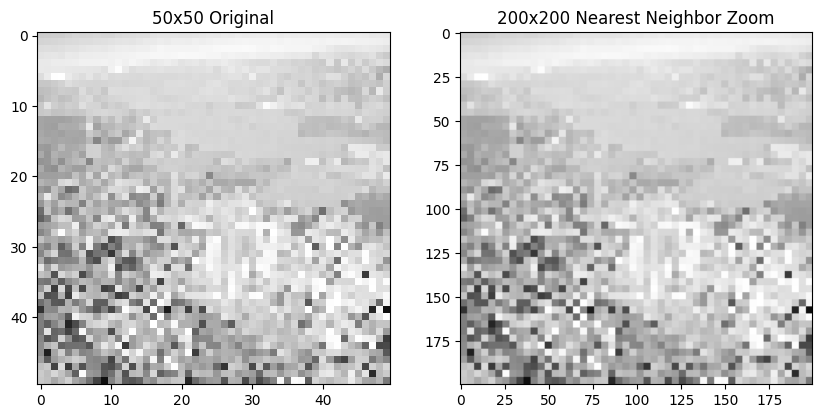

In [8]:
def manual_zoom_nn(img, s):
    h, w = img.shape[:2]
    nh, nw = int(h*s), int(w*s)
    res = np.zeros((nh, nw, 3) if len(img.shape)==3 else (nh, nw), dtype=img.dtype)
    for i in range(nh):
        for j in range(nw):
            res[i, j] = img[min(int(i/s), h-1), min(int(j/s), w-1)]
    return res

original_img = load_assign_image('Sources/runway.png')
small = cv2.resize(original_img, (50, 50))
zoomed_nn = manual_zoom_nn(small, 4.0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(small); plt.title("50x50 Original")
plt.subplot(1, 2, 2); plt.imshow(zoomed_nn); plt.title("200x200 Nearest Neighbor Zoom")
plt.show()

Question 8 (Salt and Pepper Noise)

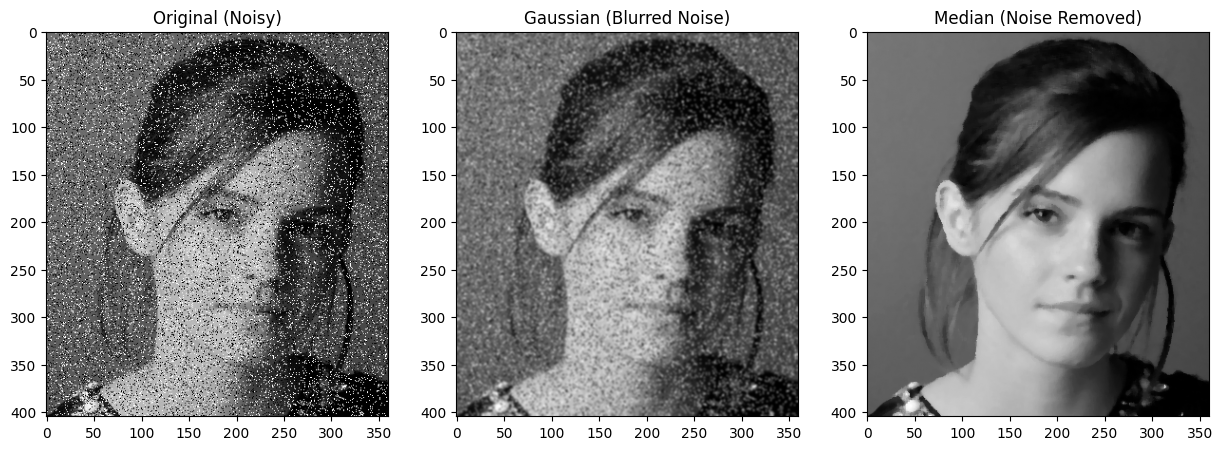

In [9]:
img_q8 = load_assign_image('Sources/emma_salt_pepper.jpg', gray=True)

# Apply Gaussian (Linear) vs Median (Non-linear)
gauss_res = cv2.GaussianBlur(img_q8, (5, 5), 0)
median_res = cv2.medianBlur(img_q8, 5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_q8, cmap='gray'); plt.title("Original (Noisy)")
plt.subplot(1, 3, 2); plt.imshow(gauss_res, cmap='gray'); plt.title("Gaussian (Blurred Noise)")
plt.subplot(1, 3, 3); plt.imshow(median_res, cmap='gray'); plt.title("Median (Noise Removed)")
plt.show()

Question 9 (Image Sharpening)

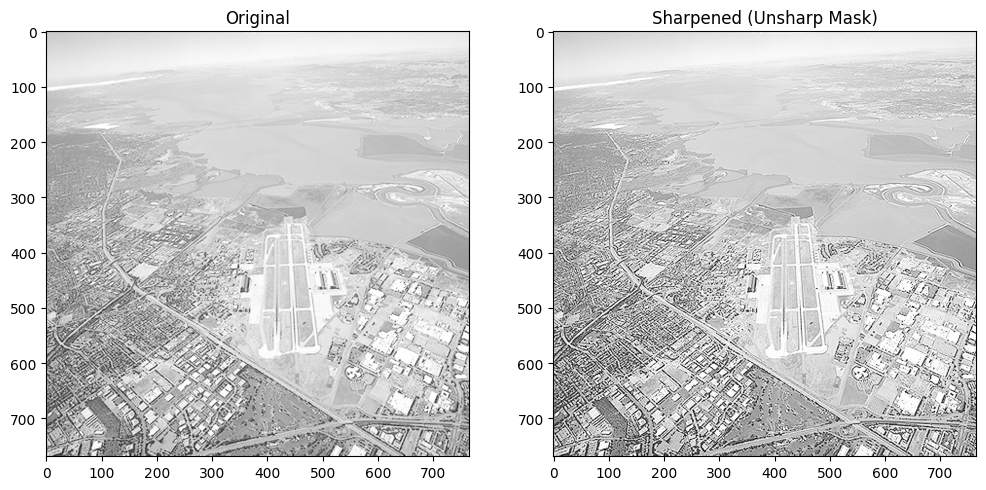

In [10]:
img_q9 = load_assign_image('Sources/runway.png', gray=True)

# Unsharp Masking: Sharpened = Original + strength * (Original - Blurred)
blurred = cv2.GaussianBlur(img_q9, (5, 5), 1.0)
detail = img_q9.astype(float) - blurred.astype(float)
sharpened = np.clip(img_q9.astype(float) + 1.5 * detail, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(img_q9, cmap='gray'); plt.title("Original")
plt.subplot(1, 2, 2); plt.imshow(sharpened, cmap='gray'); plt.title("Sharpened (Unsharp Mask)")
plt.show()

Question 10 (Bilateral Filtering)

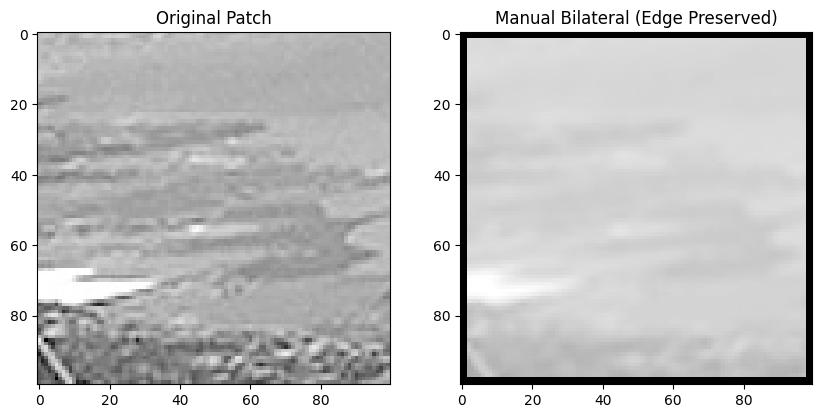

In [11]:
img_q10 = load_assign_image('Sources/runway.png', gray=True)
# Manual bilateral is slow; showing 100x100 patch for instant results
patch = img_q10[100:200, 100:200]

def bilat_func(img, d, s_s, s_r):
    out = np.zeros_like(img, dtype=float)
    rad = d // 2
    for i in range(rad, img.shape[0]-rad):
        for j in range(rad, img.shape[1]-rad):
            reg = img[i-rad : i+rad+1, j-rad : j+rad+1].astype(float)
            # Spatial weights
            y, x = np.ogrid[-rad:rad+1, -rad:rad+1]
            w_s = np.exp(-(x**2 + y**2) / (2 * s_s**2))
            # Intensity weights
            w_r = np.exp(-(reg - img[i, j])**2 / (2 * s_r**2))
            w = w_s * w_r
            out[i, j] = np.sum(reg * w) / np.sum(w)
    return out.astype(np.uint8)

res_bilat = bilat_func(patch, 5, 75, 75)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(patch, cmap='gray'); plt.title("Original Patch")
plt.subplot(1, 2, 2); plt.imshow(res_bilat, cmap='gray'); plt.title("Manual Bilateral (Edge Preserved)")
plt.show()